# Jones scalars observables (noisy angular quantities) with uncertainty inference

This is a simple physics model where our data, $y$, is modelled as the principle argument of a unitary complexy vector with white noise added, i.e. the phase of a complex RV, $\phi_\nu = K \tau \nu^{-1} + M \eta \nu + \epsilon$

$L(x) = P(y | x) = \mathcal{N}[y \mid \phi_{\rm obs},\sigma^2 \mathbf{I}]$

where $\phi_{\rm obs} = \Arg Y$ and $Y \sim \mathcal{N}(\phi, \sigma^2)$

and we take the priors,

$P(\tau) = \mathcal{C}[\tau \mid 0, 100]$ (Cauchy)


$P(\eta) = \mathcal{U}[\eta \mid -2, 2]$ (Uniform)


$P(\epsilon) = \mathcal{U}[\epsilon \mid -\pi, \pi]$ (Uniform)


$P(\sigma) = \mathcal{H}[\sigma \mid 0.5]$ (Half-Laplace)





## Overview

We'll cover the following topics:

1. How to define a hierarchical model using `PriorChain`.
2. How to define _a_ likelihood with angular parameters.
3. How to brute-force compute the evidence for comparison.
4. How to compute Bayesian evidence of your model with standard nested sampling (without much tuning of parameters).
5. How to inspect and plot your results.

In [10]:
from jaxns.nested_sampler.nested_sampling import NestedSampler
from jaxns.plotting import plot_diagnostics, plot_cornerplot
from jaxns.utils import summary, analytic_log_evidence
from jaxns.prior_transforms import UniformPrior, PriorChain, HalfLaplacePrior, CauchyPrior
from jax import jit
from jax import numpy as jnp, random
import pylab as plt

In [14]:

TEC_CONV = -8.4479745#rad*MHz/mTECU
CLOCK_CONV = (2e-3*jnp.pi)#rad/MHz/ns

def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi

def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component, where the clock are shared for all data,
    and the tec are different:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)#MHz
    tec = 90.#mTECU
    const = 2.#rad
    clock = 0.5#ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs


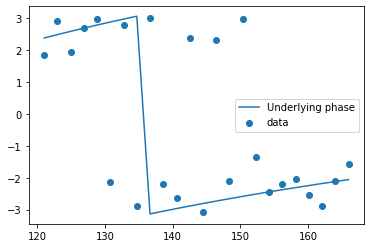

In [15]:
# Generate data
key = random.PRNGKey(42)
key,data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.5)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve.

In [16]:

def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale)  - 0.5 * dx * dx

def log_likelihood(tec, const, clock, uncert, **kwargs):
    phase = tec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)

with PriorChain() as prior_chain:
    CauchyPrior('tec', 0., 100.)
    UniformPrior('const', -jnp.pi, jnp.pi)
    UniformPrior('clock', -2., 2.)
    HalfLaplacePrior('uncert', 0.5)

prior_chain.build()
log_Z = analytic_log_evidence(prior_chain,log_likelihood, S=60)

print(f"True log(Z): {log_Z}")

ns = NestedSampler(log_likelihood, prior_chain)

results = jit(ns)(key, num_live_points=prior_chain.U_ndims*100)

WARNING[2022-03-03 02:17:01,857]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.


True log(Z): -29.788313126980285


WARNING[2022-03-03 02:17:17,417]: No handles with labels found to put in legend.


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 455968
# samples: 5158
# likelihood evals / sample: 88.4
--------
logZ=-29.82 +- 0.12
H=520.0
ESS=934
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: 0.0 +- 1.1 | -1.5 / 0.0 / 1.6 | -1.5 | -1.4
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 0.0 +- 1.8 | -2.4 / -0.1 / 2.6 | 0.5 | -1.1
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 87.0 +- 30.0 | 50.0 / 87.0 / 129.0 | 142.0 | 114.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.67 +- 0.1 | 0.55 / 0.66 / 0.81 | 0.67 | 0.62
--------


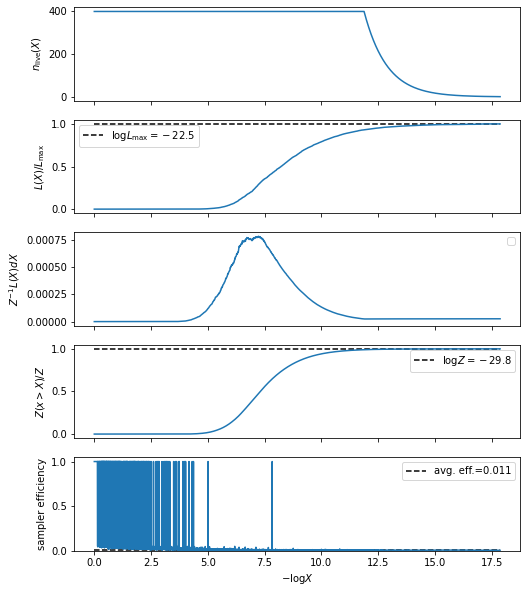

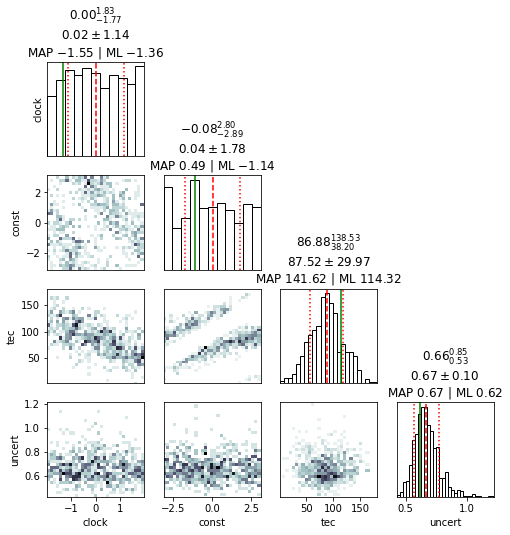

In [17]:
# Plot solutions
summary(results)
plot_diagnostics(results)
plot_cornerplot(results)
